# Natural Language Processing: Bernoulli Naive Bayes vs Random Forest
### By: Corina Lentz
---



## Problem Statement

More businesses are making the transition into online sales [*source*](https://fortune.com/2020/07/15/ecommerce-online-shopping-coronavirus-business-trends-covid/), which means an increased demand for predicting online shopping behavior, using methods such as Natural Language Processing (or NLP). The medical field is also turning to artificial intelligence to automate electronic medical and health records through NLP [*source*](https://healthtechmagazine.net/article/2021/07/how-can-healthcare-leverage-natural-language-processing-medical-records-perfcon). But which NLP model will give the most accurate predictions, given two possible outcomes? In this project we will compare the Bernoulli Naive Bayes and Random Forest NLP models, to see which one is the most accurate.

---

## Background

Natural Language Processing was created in the 1950s but it wasn't until the late 1980s into the early 1990s when machine learning was created and integrated into NLP that it really became the robust language processing system that we know today [*source*](https://en.wikipedia.org/wiki/Natural_language_processing). The first algorithm used for Random Forest was created in 1995, but Random Forest itself was created and trademarked in 2006 [*source*](https://en.wikipedia.org/wiki/Random_forest). Bernoulli Naive Bayes is based on the Bayes Theorem which was published in 1765 [*source*](https://en.wikipedia.org/wiki/Bayes'_theorem). 

---

## Data

For this project I used Pushshift's Reddit API [*source*](https://github.com/pushshift/api) to scrape the posts from two subreddits: r/horror [*source*](https://www.reddit.com/r/horror/) and r/Fantasy [*source*](https://www.reddit.com/r/Fantasy/). I collected 5000 posts from each subreddit for a total of 10000 posts. Please see the Jupyter Lab notebook 'data-collection-notebook.ipynb' to see the code for and notes on the data collecting process.

---

## Data Dictionary

|Feature|Description|
|---|---|
|**subreddit**|Indicates which subreddit the post is from ('horror' indicates the r/horror subreddit and 'fantasy' indicates the r/Fantasy subreddit). Note: This column is later binarized and renamed 'is_horror' (please see below).|
|**title**|The title of the Reddit post.|
|**selftext**|The subtitle of the Reddit post which is an optional description of the post itself. Note: If there is a NaN value in this column it means either the post did not have a subtitle or that the post's subtitle was removed by the author before the data was collected.|
|**title_selftext**|The text from the 'title' and 'selftext' columns merged into one single string.|
|**is_horror**|The 'subreddit' column has been binarized so that 1 indicates the r/horror subreddit and 0 would indicate the r/Fantasy subreddit. The column name has been updated to reflect this binary.|

---

## Data Cleaning & Pre-Processing

In [1]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import re
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Increasing the number of characters visible in a single column
pd.options.display.max_colwidth=100
#Also increasing number of columns displayed
pd.set_option('display.max_columns', 100)

In [3]:
#Reading in the dataframe
full_df=pd.read_csv('../data/full_reddit_submissions')

C:\Users\rinet\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (19,80,86,87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Received a warning due to the size of the dataframe being read in. Didn't cause any computer issues or affect the dataframe. Not a concern at this time.

In [4]:
#Creating a new dataframe to save our columns to.
df=pd.DataFrame()

In [5]:
#Pulling out the three pieces of data we're concerned with and save them to the new dataframe to make it easier to work with.
df['subreddit']=full_df['subreddit']
df['title']=full_df['title']
df['selftext']=full_df['selftext']

In [6]:
#Taking a look at the size of the new dataframe and the first/last 5 rows.
print(df.shape)
df.head()

(10000, 3)


,subreddit,title,selftext
0,horror,Disturbing recommendations,[removed]
1,horror,Grant's+Promo+Codes+—+Grant+Van+Rooyen,NaN
2,horror,What twist are you sick of seeing?,"For me any iteration of ""this person was dead the whole time"" There are tons of films that do th..."
3,horror,You Have Been Warned: ‘The Omen’ Turns 45,NaN
4,horror,What's your favorite revenge horror film? They're some of my favorites so im always looking for ...,[removed]


In [7]:
df.tail()

,subreddit,title,selftext
9995,Fantasy,"David Gemmell's ""Knights of Dark Renown"" is a solid popcorn fantasy that combines demons and vam...","I'm calling this a ""popcorn fantasy"" in the same vein as something like Riyria, Drizzt, Riftwar,..."
9996,Fantasy,"Final draft of Rhythm of War, Book 4 of Stormlight Archive is done!",NaN
9997,Fantasy,Favorite magic of all time?,What are some of your favorite magical abilities/ spells/etc that you have read about? Even favo...
9998,Fantasy,Little Known Epic Books Series?,I am wondering if there are any decent epic fantasy series that aren't really well known. Someth...
9999,Fantasy,What fantasy creature is the scariest/creepiest?,NaN


In [8]:
#Checking our NaN values.
df.isnull().sum()

subreddit       0
title           0
selftext     2744
dtype: int64

Already seeing NaN values and [removed] in the 'selftext' column. Fortunately it's the only column with NaN values. Converting the [removed] values to NaNs. These posts having a subtitle that was later removed isn't really a concern and these are effectively NaN values for our purposes.

In [9]:
df['selftext'].replace(to_replace='[removed]', value=np.nan, inplace=True)

In [10]:
df.head()

,subreddit,title,selftext
0,horror,Disturbing recommendations,NaN
1,horror,Grant's+Promo+Codes+—+Grant+Van+Rooyen,NaN
2,horror,What twist are you sick of seeing?,"For me any iteration of ""this person was dead the whole time"" There are tons of films that do th..."
3,horror,You Have Been Warned: ‘The Omen’ Turns 45,NaN
4,horror,What's your favorite revenge horror film? They're some of my favorites so im always looking for ...,NaN


Now I'll create a third column called 'title_selftext' that combines the strings in our 'title' and 'selftext' columns into a single string. This will allow me to review all of the text in both the title and subtitle without needing to drop any of the observances where 'selftext' is a NaN value (especially since nearly half of the values for 'selftext' are NaNs).

In [11]:
#First I'm replacing the NaN values in 'selftext' with "" and saving it to a variable.
selftext_cleaned=df['selftext'].replace(to_replace=np.nan, value="")

In [12]:
#Now I'll create the new column
df['title_selftext']=df['title'].astype(str)+ " " + selftext_cleaned

#And lastly I'll strip the leading and trailing white space.
df['title_selftext']=[value.strip() for value in df['title_selftext']]

In [13]:
#Reviewing first 5 rows
df.head()

,subreddit,title,selftext,title_selftext
0,horror,Disturbing recommendations,NaN,Disturbing recommendations
1,horror,Grant's+Promo+Codes+—+Grant+Van+Rooyen,NaN,Grant's+Promo+Codes+—+Grant+Van+Rooyen
2,horror,What twist are you sick of seeing?,"For me any iteration of ""this person was dead the whole time"" There are tons of films that do th...","What twist are you sick of seeing? For me any iteration of ""this person was dead the whole time""..."
3,horror,You Have Been Warned: ‘The Omen’ Turns 45,NaN,You Have Been Warned: ‘The Omen’ Turns 45
4,horror,What's your favorite revenge horror film? They're some of my favorites so im always looking for ...,NaN,What's your favorite revenge horror film? They're some of my favorites so im always looking for ...


When I started EDA I realized that there are a fair number of URLs imbedded in the titles and selftext. Unfortunately these are adding noise to my data, so I'm removing them from the 'title_selftext' column (as that is the column I'm using for my feature). Using code found here: https://stackoverflow.com/questions/24399820/expression-to-remove-url-links-from-twitter-tweet .

In [14]:
#Creating an empty list that the cleaned values can be added to
no_web_addr=[]

#Iterating through the values in 'title_selftext' column
for value in df['title_selftext']:
    
    #Using this regex code to remove the URLs from each value
    result = re.sub(r"http\S+", "", value)
    #Then appending the cleaned values to our empty list.
    no_web_addr.append(result)

In [15]:
df['title_selftext']=no_web_addr

Now I'll binarize the 'subreddit' column so it can be used in models and rename it 'is_horror' to be consistent with the new binary.

In [16]:
#Renaming 'subreddit' column to 'is_horror'.
df=df.rename(columns={'subreddit':'is_horror'})

#binarizing with 1=horror and 0=fantasy.
df['is_horror']=[1 if value=='horror' else 0 for value in df['is_horror']]

---

## EDA

During my initial EDA I discovered there are common stopwords written with unusual characters that weren't being filtered out. Using .extend() on the 'english' stopwords list to add these recurring words along with words written in a language I don't know. Unfortunately there are a wide range of numbers that act like strings so they need to be listed out individually to be removed. There are too many for me to remove them all due to computer limitations. I'll try to thin them out while leaving the ones that could be relevant. Note: After completing initial EDA I discovered that both subreddits shared some common high-frequency words that made it difficult to get good accuracy. Adding these words to the stpwrd list.

In [17]:
stpwrd = stopwords.words('english')

stpwrd.extend(['00', '000', '01', '001', '015', '02', '03', '04', '06', '07', '08', '09', '101', '103', '104',
               '106', '107', '108', '109', '110', '111', '112', '113', '116', '117', '118', '120', '121', '122', '123', '123movies', 
               '123movies4u', '124', '125', '127', '128', '129', '130', '132', '133', '135', '137', '138', '139', '14', '140', '142', '143', '145', 
               '146', '147', '149', '15', '150', '151', '152', '153', '155', '156', '158', '160', '161', '162', '163', '165', '168', '169', 
               '17', '170', '1700', '172', '173', '174', '176', '177', '18', '180', '1800', '181', '184', '1840', '19', '190', '191', '192', '195',
               '196', '197', '198', '199', '20', '200', '201', '202', '203', '204', '205', '26', '266', '27', '270', '272', '277', '287', 
               '29', '290', '291', '295', '296', '298', '207', '208', '21', '210', '211', '213', '215', '218', '22', '220', '221', '222', '225', 
               '229', '230', '234', '235', '237', '239', '24', '246', '25', '250', '300', '3000', '306', '308', '310', '317', '318',
               '32', '326', '33', '335', '336', '338', '34', '35', '352', '36', '37', '38', '39', '40', '400', '41', '43', '44', '45', '450', '46',
               '48', 'like', 'one', 'first', 'would', 'really', 'time', 'good', 'get', 'think', 'people', 'know', 'аnd', 'оf', 'оnly', 'оwn', 
               'тhere', 'الواحدي', 'ناصر'])

Using CountVectorizer on the 'title_selftext' column. 

In [18]:
#Instantiating our CountVectorizer transformer and using the newly created stpwrds list.
cvec = CountVectorizer(stop_words=stpwrd, min_df=3)

#Fitting cvec
cvec.fit(df['title_selftext'])

#Saving as a variable.
ttl_selftxt_cvec=cvec.transform(df['title_selftext'])

In [19]:
#Turning it into a dataframe.
ttl_selftxt_df=pd.DataFrame(data=ttl_selftxt_cvec.todense(), columns=cvec.get_feature_names())

#Adding the 'is_horror' column to this new dataframe.
ttl_selftxt_df['is_horror']=df['is_horror']

I'd also like to take a look at the word count and character count of the 'title_selftext' column. Creating columns for each of those in our original df.

In [20]:
#Creating the word count column
df['word_count']=df['title_selftext'].map(lambda x: len(x.split()))

#Creating the character count column
df['character_count']=df['title_selftext'].map(len)

In [21]:
df.head()

,is_horror,title,selftext,title_selftext,word_count,character_count
0,1,Disturbing recommendations,NaN,Disturbing recommendations,2,26
1,1,Grant's+Promo+Codes+—+Grant+Van+Rooyen,NaN,Grant's+Promo+Codes+—+Grant+Van+Rooyen,1,38
2,1,What twist are you sick of seeing?,"For me any iteration of ""this person was dead the whole time"" There are tons of films that do th...","What twist are you sick of seeing? For me any iteration of ""this person was dead the whole time""...",41,202
3,1,You Have Been Warned: ‘The Omen’ Turns 45,NaN,You Have Been Warned: ‘The Omen’ Turns 45,8,41
4,1,What's your favorite revenge horror film? They're some of my favorites so im always looking for ...,NaN,What's your favorite revenge horror film? They're some of my favorites so im always looking for ...,18,109


In [22]:
#Taking a look at the size
ttl_selftxt_df.shape

(10000, 15098)

In [23]:
#Taking a look at the first 5 rows
ttl_selftxt_df.head()

,00s,10,100,1000,10am,10th,11,11th,12,12th,13,13th,14th,15th,16,16th,17th,1800s,18th,1910,1920,1920s,1921,1930s,1931,1950s,1952,1954,1957,1959,1960,1960s,1962,1963,1964,1965,1966,1967,1968,1969,1970,1970s,1971,1972,1973,1974,1975,1976,1977,1978,...,yet,yield,yikes,yin,ymmv,yo,yogurt,yong,yoon,york,young,younger,youngest,youth,youthful,youths,youtube,youtuber,youtubers,youve,yrs,yt,yucatán,yum,yup,yоutuber,zachary,zack,zaya,zealand,zeke,zelazny,zelda,zen,zero,zeus,zine,zodiac,zoe,zombie,zombies,zone,zones,zong,zoom,zoomed,zooming,zorian,zuko,is_horror
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [24]:
#Checking our class balance and baseline score
ttl_selftxt_df['is_horror'].value_counts(normalize=True)

0    0.5
1    0.5
Name: is_horror, dtype: float64

As expected, we have an even 50/50 split between our 0 and 1 classes. This makes sense as an equal number of r/horror and r/Fantasy posts were collected and we didn't have to drop any rows during cleaning. Stratifying won't be needed. This also gives us a fairly low baseline of 0.5 .

In [25]:
#Setting-up variables so I can easily explore both our classes, starting with our original df.
horror=df[df['is_horror']==1]
horror=horror.drop(columns=['is_horror'])

#Now for the fantasy class
fantasy=df[df['is_horror']==0]
fantasy=fantasy.drop(columns=['is_horror'])

In [26]:
#Doing the same thing with the ttl_selftxt_df
horror_cv=ttl_selftxt_df[ttl_selftxt_df['is_horror']==1]
horror_cv=horror_cv.drop(columns=['is_horror'])

#And the fantasy class
fantasy_cv=ttl_selftxt_df[ttl_selftxt_df['is_horror']==0]
fantasy_cv=fantasy_cv.drop(columns=['is_horror'])

In [27]:
#Reviewing the top 20 words for r/horror (our 1 class)
horror_cv.sum().sort_values(ascending=False).head(20)

horror       3157
movie        2609
film         1325
movies       1320
watch         751
seen          597
films         539
see           534
also          519
something     509
watched       495
even          470
find          460
anyone        449
watching      448
could         446
made          441
new           439
story         438
scene         438
dtype: int64

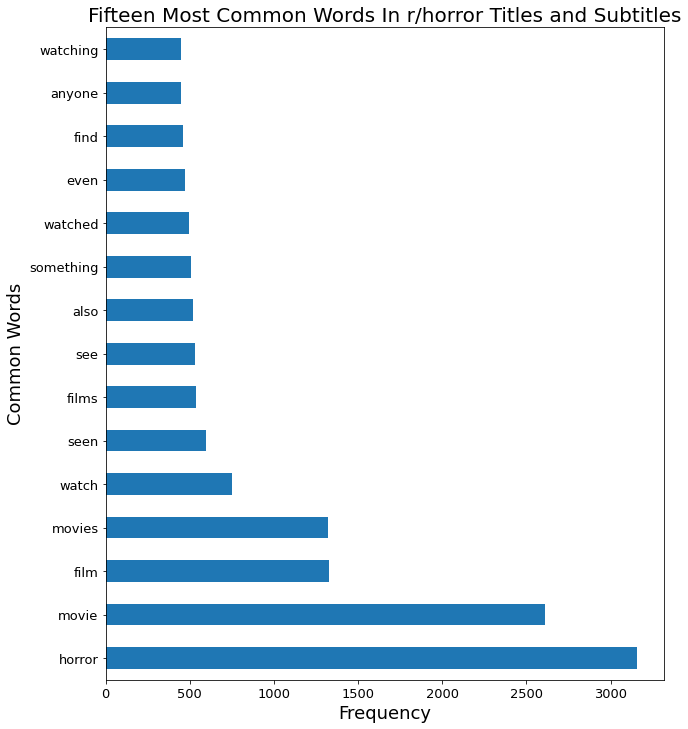

In [28]:
#Plotting the words for easy comparison
horror_cv.sum().sort_values(ascending=False).head(15).plot(kind='barh', figsize=(10, 12));

#Setting title
plt.title("Fifteen Most Common Words In r/horror Titles and Subtitles", fontsize = 20)

#Labeling x-axis and adjusting fontsizes
plt.xlabel('Frequency', fontsize=18)
plt.xticks(fontsize=13)

#Labeling y-axis and adjusting fontsizes
plt.ylabel('Common Words', fontsize=18)
plt.yticks(fontsize=13);

In [29]:
#Reviewing the top 20 words for r/fantasy (our 0 class)
fantasy_cv.sum().sort_values(ascending=False).head(20)

book          5925
fantasy       4954
books         3863
read          3562
series        3292
story         2298
world         2251
characters    2121
also          2030
reading       1560
well          1542
much          1531
even          1504
character     1504
magic         1433
love          1387
something     1344
way           1342
new           1289
want          1287
dtype: int64

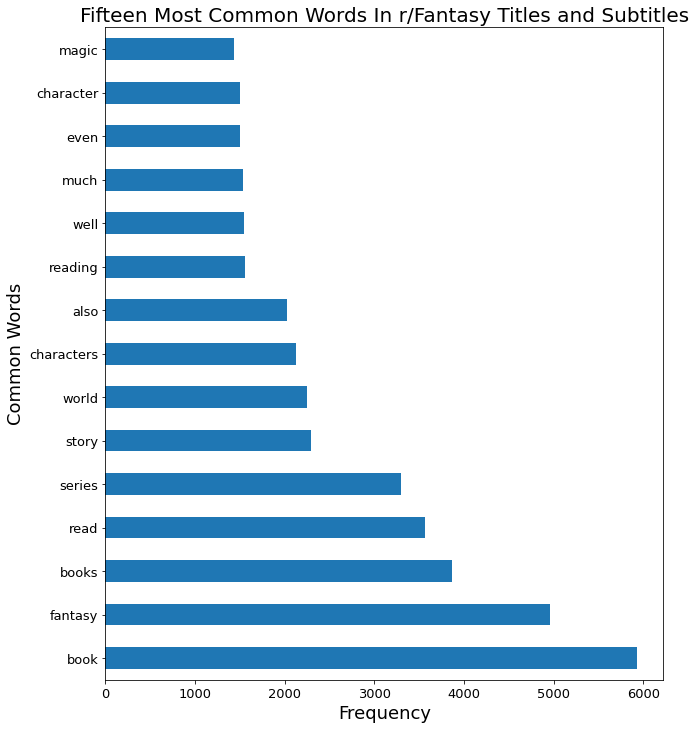

In [30]:
#Also plotting the words for easy comparison
fantasy_cv.sum().sort_values(ascending=False).head(15).plot(kind='barh', figsize=(10, 12));

#Setting title
plt.title("Fifteen Most Common Words In r/Fantasy Titles and Subtitles", fontsize = 20)

#Labeling x-axis and adjusting fontsizes
plt.xlabel('Frequency', fontsize=18)
plt.xticks(fontsize=13)

#Labeling y-axis and adjusting fontsizes
plt.ylabel('Common Words', fontsize=18)
plt.yticks(fontsize=13);

Interesting to see that the top 20 words for fantasy have higher frequencies than the top 20 words for horror. The top words for the horror class seem to centered around movies and movie content, while the fantasy class centers around books and book content.

**Note**: Both classes originally had the following words in their top 20 words: like, one, first, would, really, time, good, get, think, people, and know. I initially left the shared words in, however this had a negative impact on model accuracy so I have since added them to the stpwrd list.

Now I'll take a look at the 20 words with the lowest frequencies for each class.

In [31]:
#Reviewing the 20 most infrequent words for the horror class.
horror_cv.sum().sort_values(ascending=True).head(20)

lament            0
invented          0
invent            0
invading          0
invaded           0
intruding         0
introverted       0
intrigues         0
intricately       0
intimidated       0
invention         0
intimate          0
interweaving      0
intertwined       0
intersting        0
interspersed      0
interrogation     0
interplay         0
interplanetary    0
interpersonal     0
dtype: int64

In [32]:
#Reviewing the 20 most infrequent words for the fantasy class.
fantasy_cv.sum().sort_values(ascending=True).head(20)

dowtown       0
hellraiser    0
blandness     0
lynda         0
nosferatu     0
valak         0
macabre       0
uzumaki       0
blacula       0
blackwell     0
ezekiel       0
noroi         0
macready      0
madison       0
angie         0
urged         0
blackcoat     0
tequesta      0
eyeballs      0
dreaddit      0
dtype: int64

Unfortunately our vectored data appears to include words that appear several times within the actual subreddit posts but do not appear in the titles/subtitles that our study is interested in.

In [33]:
#Looking at the first 20 titles/subtitles with the smallest word counts for the horror class
horror.sort_values(by= 'word_count', ascending=True)[['title_selftext', 'word_count']].head(20)

,title_selftext,word_count
2946,,0
527,,0
351,,0
2192,,0
4439,YouTube,1
1524,Movie,1
2613,Soordas,1
2618,app1355025.apk,1
4505,Backtrack,1
1445,TheSpookyScreen.com,1


In [34]:
#Looking at the first 20 titles/subtitles with the smallest word counts for the fantasy class
fantasy.sort_values(by= 'word_count', ascending=True)[['title_selftext', 'word_count']].head(20)

,title_selftext,word_count
9174,,0
7877,ONLYFANS,1
7566,ONLYFANS,1
7529,Ce?,1
7521,ONLYFANS,1
5546,r/abidangames,1
9343,#Fantasy,1
7408,ONLYFANS,1
7407,ONLYFANS,1
7405,ONLYFANS,1


In the horror class the titles/subtitles with the lowest word counts are either empty, appear to be advertising something, or seem to be for some sort of technical integration. In the fantasy class the majority of the titles/subtitles with the lowest word counts appear to be advertising.

In [35]:
#Looking at the first 20 titles/subtitles with the largest word counts for the horror class
horror.sort_values(by= 'word_count', ascending=False)[['title_selftext', 'word_count']].head(20)

,title_selftext,word_count
485,Since March of last year I've watched nearly a thousand horror movies so you don't have to. Need...,6739
2746,"V. Reparations &amp;nbsp;\r\n\r\nPrize Water Township hasn’t much for environmental stress, layi...",5248
2748,"V. Reparations \r\n\r\n\r\n \r\nPrize Water Township hasn’t much for environmental stress, layi...",5138
1500,Till Death Do Us Part Till death do us part was a saying that Liam Nesbitt never really unde...,4283
3566,Thirteen Ghosts (1960 vs. 2001) - Which do you prefer? One of these films is emblematic of Willi...,2619
4818,A Man at the Theatre [Sam Sueseide wasn't a particularly important person. Most people who met h...,2603
2387,The Will of The Machine \r\n\r\nMired earth entrenched their fingernails as they hoisted themse...,2226
332,Come True (2020) is an insult to the horror genre: my vewy angwy weview about this film I was so...,1964
3994,The scariest dream I’ve ever had. This is going to be a long one but I’ll try my best to make it...,1916
4063,Universal took Tremors from its creators after 30 years of work. ***MAJOR SPOILERS*** This may m...,1826


In [36]:
#Looking at the first 20 titles/subtitles with the largest word counts for the fantasy class
fantasy.sort_values(by= 'word_count', ascending=False)[['title_selftext', 'word_count']].head(20)

,title_selftext,word_count
6607,[Review] The City and the City by China Mieville (The following review is a transcription from a...,6793
6064,Riordan Retrospective: The Tyrant’s Tomb and The Tower of Nero Welcome once again to the Riordan...,6594
6748,2020 r/Fantasy Bingo Statistics *Administrative Note: Ever since I discovered the* r/Fantasy *Bi...,6336
5341,GRIT Book 1 Description: Olv is a young man who struggles working his day job at the local mine...,6142
6750,"u/TehLittleOne's May Reading Stats and Mini Reviews Hey everyone, hope you all read some good bo...",5770
8324,Riordan Retrospective: The House of Hades and The Blood of Olympus Welcome once again to the Rio...,5153
6656,Riordan Retrospective: Camp Half-Blood Confidential and Camp Jupiter Classified Welcome once aga...,4794
5014,Riordan Retrospective: The Hammer of Thor and The Ship of the Dead Welcome once again to the Rio...,4559
9755,Climbing Mount Readmore: Reading Our Top Fantasy Novels Part 23 - 34-30 Welcome to the home stre...,4363
7673,The Girl and the Mountain in-depth discussion (SPOILERS AND SPOILERS AND SPOILERS) \r\n\r\n# Th...,4296


For both classes the titles/subtitles with the largest word counts are from the author putting their entire post into the title/subtitle section. For the horror class the largest word counts include short stories, movie reviews, and movie recommendation lists. The largest word counts for the fantasy class are from book reviews, book recommendation lists, and short stories. This is consistent with the top words for both classes. The horror class has a lower concentration of words than the fantasy class, which is also consistent with the frequencies seen in the top words.

---

In [101]:
#Now that I've complete EDA and all my cleaning, I'm saving my dataframe to .csv .
df.to_csv('../data/cleaned_processed_dataframe.csv', index=False)

---

## Modeling

**Bernoulli Naive Bayes Model**

The first model I will be working with is the Bernoulli Naive Bayes model and I'll be using a pipeline to calculate the best hyperparameters for my CountVectorizer.

In [37]:
X=df['title_selftext']
y=df['is_horror']

#First I'll train-test-split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=111)

In [38]:
#Calculating our baseline accuracy here for easy reference.
baseline=y.value_counts(normalize=True)
baseline

0    0.5
1    0.5
Name: is_horror, dtype: float64

Our baseline accuracy is evenly split 50% for our 0 class (r/fantasy) and 50% for our 1 class (r/horror).

In [39]:
#Creating my basic pipeline and saving it to 'pipe'.
pipe_cvec=Pipeline([
    ('cvec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

In [40]:
#Setting-up my pipeline parameters to be searched over.
pipe_params = {
    'cvec__stop_words'   : [stpwrd, None],
    'cvec__max_features' : [3000, 6000],
    'cvec__min_df'       : [2, 3],
    'cvec__max_df'       : [0.9, 0.98],
    'cvec__ngram_range'  : [(1, 2), (1, 3)]
}

#Plugging everything into the GridSearchCV.
gs = GridSearchCV(estimator = pipe_cvec,
                  param_grid=pipe_params, 
                  cv=5, 
                  verbose = 1,
                n_jobs=6) 

In [41]:
#Fitting GridSearchCV to the training data.
gs.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             n_jobs=6,
             param_grid={'cvec__max_df': [0.9, 0.98],
                         'cvec__max_features': [3000, 6000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 2), (1, 3)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself'

In [42]:
#Taking a look at the best score
gs.best_score_

0.7492537313432835

In [43]:
#Reviewing the best params
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',

The best parameters are either the largest or smallest numbers from each of our hyperparameter options. It's possible these could be optimized further. I'll adjust the parameters and try again.

In [44]:
#Adjusting the pipeline and re-fitting the model
pipe_params = {
    'cvec__stop_words'   : [stpwrd],
    'cvec__max_features' : [3000, 5000],
    'cvec__min_df'       : [3, 4],
    'cvec__max_df'       : [0.9, 0.95],
    'cvec__ngram_range'  : [(1, 1), (1, 2)]
}

#Plugging new pipeline into the GridSearchCV.
gs = GridSearchCV(estimator = pipe_cvec,
                  param_grid=pipe_params, 
                  cv=5, 
                  verbose = 1,
                n_jobs=6) 

In [45]:
#Re-fitting GridSearchCV to the training data.
gs.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             n_jobs=6,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [3000, 5000],
                         'cvec__min_df': [3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself'

In [46]:
#Taking a look at the best score
gs.best_score_

0.7492537313432835

In [47]:
#Reviewing the best params
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',

The ngram_range is staying at (1, 2) and min_df is staying at 3. Those seem to be the best settings for those params. The other 2 still have some room for improvement.

In [48]:
#Adjusting the pipeline and re-fitting the model
pipe_params = {
    'cvec__stop_words'   : [stpwrd],
    'cvec__max_features' : [2000, 3000, 4000],
    'cvec__min_df'       : [3],
    'cvec__max_df'       : [0.85, 0.9, 0.94],
    'cvec__ngram_range'  : [(1, 2)]
}

#Plugging new pipeline into the GridSearchCV.
gs = GridSearchCV(estimator = pipe_cvec,
                  param_grid=pipe_params, 
                  cv=5, 
                  verbose = 1,
                n_jobs=6) 

In [49]:
#Re-fitting GridSearchCV to the training data.
gs.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             n_jobs=6,
             param_grid={'cvec__max_df': [0.85, 0.9, 0.94],
                         'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [3], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
        

In [50]:
#Taking a look at the best score
gs.best_score_

0.7494029850746269

In [51]:
#Reviewing the best params
gs.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 2000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below'

Still room for improvement in the max_df and max_features. Adjusting the params and refitting.

In [52]:
#Adjusting the pipeline and re-fitting the model
pipe_params = {
    'cvec__stop_words'   : [stpwrd],
    'cvec__max_features' : [1500, 2000, 2500],
    'cvec__min_df'       : [3],
    'cvec__max_df'       : [0.8, 0.85, 0.89],
    'cvec__ngram_range'  : [(1, 2)]
}

#Plugging new pipeline into the GridSearchCV.
gs = GridSearchCV(estimator = pipe_cvec,
                  param_grid=pipe_params, 
                  cv=5, 
                  verbose = 1,
                n_jobs=6) 

In [53]:
#Re-fitting GridSearchCV to the training data.
gs.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             n_jobs=6,
             param_grid={'cvec__max_df': [0.8, 0.85, 0.89],
                         'cvec__max_features': [1500, 2000, 2500],
                         'cvec__min_df': [3], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
        

In [54]:
#Taking a look at the best score
gs.best_score_

0.7546268656716417

In [55]:
#Reviewing the best params
gs.best_params_

{'cvec__max_df': 0.8,
 'cvec__max_features': 1500,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',

Both max_df and max_features continue to be the lowest values. Adjusting and refitting.

In [56]:
#Adjusting the pipeline and re-fitting the model
pipe_params = {
    'cvec__stop_words'   : [stpwrd],
    'cvec__max_features' : [500, 1000, 1500],
    'cvec__min_df'       : [3],
    'cvec__max_df'       : [0.7, 0.75, 0.8],
    'cvec__ngram_range'  : [(1, 2)]
}

#Plugging new pipeline into the GridSearchCV.
gs = GridSearchCV(estimator = pipe_cvec,
                  param_grid=pipe_params, 
                  cv=5, 
                  verbose = 1,
                n_jobs=6) 

In [57]:
#Re-fitting GridSearchCV to the training data.
gs.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             n_jobs=6,
             param_grid={'cvec__max_df': [0.7, 0.75, 0.8],
                         'cvec__max_features': [500, 1000, 1500],
                         'cvec__min_df': [3], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
          

In [58]:
#Taking a look at the best score
gs.best_score_

0.7641791044776118

In [59]:
#Reviewing the best params
gs.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 500,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',


Continuing to adjust max_features and max_df.

In [60]:
#Adjusting the pipeline and re-fitting the model
pipe_params = {
    'cvec__stop_words'   : [stpwrd],
    'cvec__max_features' : [100, 250, 500],
    'cvec__min_df'       : [3],
    'cvec__max_df'       : [0.5, 0.6, 0.7],
    'cvec__ngram_range'  : [(1, 2)]
}

#Plugging new pipeline into the GridSearchCV.
gs = GridSearchCV(estimator = pipe_cvec,
                  param_grid=pipe_params, 
                  cv=5, 
                  verbose = 1,
                n_jobs=6) 

In [61]:
#Re-fitting GridSearchCV to the training data.
gs.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             n_jobs=6,
             param_grid={'cvec__max_df': [0.5, 0.6, 0.7],
                         'cvec__max_features': [100, 250, 500],
                         'cvec__min_df': [3], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
             

In [62]:
#Taking a look at the best score
gs.best_score_

0.7977611940298508

In [63]:
#Reviewing the best params
gs.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 100,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',


Continuing to adjust max_features and max_df.

In [64]:
#Adjusting the pipeline and re-fitting the model
pipe_params = {
    'cvec__stop_words'   : [stpwrd],
    'cvec__max_features' : [25, 50, 100],
    'cvec__min_df'       : [3],
    'cvec__max_df'       : [0.1, 0.25, 0.5],
    'cvec__ngram_range'  : [(1, 2)]
}

#Plugging new pipeline into the GridSearchCV.
gs = GridSearchCV(estimator = pipe_cvec,
                  param_grid=pipe_params, 
                  cv=5, 
                  verbose = 1,
                n_jobs=6) 

In [65]:
#Re-fitting GridSearchCV to the training data.
gs.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             n_jobs=6,
             param_grid={'cvec__max_df': [0.1, 0.25, 0.5],
                         'cvec__max_features': [25, 50, 100],
                         'cvec__min_df': [3], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
              

In [66]:
#Taking a look at the best score
gs.best_score_

0.8350746268656716

In [67]:
#Reviewing the best params
gs.best_params_

{'cvec__max_df': 0.25,
 'cvec__max_features': 25,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',


It looks like we may have found the optimal setting for max_df. I'll tighten the range of values to see if it will take something other than 0.25 . Max_features continues to favor the lowest value. Adjusting.

In [68]:
#Adjusting the pipeline and re-fitting the model
pipe_params = {
    'cvec__stop_words'   : [stpwrd],
    'cvec__max_features' : [10, 15, 20, 25],
    'cvec__min_df'       : [3],
    'cvec__max_df'       : [0.15, 0.25, 0.27],
    'cvec__ngram_range'  : [(1, 2)]
}

#Plugging new pipeline into the GridSearchCV.
gs = GridSearchCV(estimator = pipe_cvec,
                  param_grid=pipe_params, 
                  cv=5, 
                  verbose = 1,
                n_jobs=6) 

In [69]:
#Re-fitting GridSearchCV to the training data.
gs.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             n_jobs=6,
             param_grid={'cvec__max_df': [0.15, 0.25, 0.27],
                         'cvec__max_features': [10, 15, 20, 25],
                         'cvec__min_df': [3], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
         

In [70]:
#Taking a look at the best score
gs.best_score_

0.8531343283582091

In [71]:
#Reviewing the best params
gs.best_params_

{'cvec__max_df': 0.25,
 'cvec__max_features': 10,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',


The optimal setting for max_df is 0.25 so I'll leave it there. Adjusting max_features and refitting.

In [72]:
#Adjusting the pipeline and re-fitting the model
pipe_params = {
    'cvec__stop_words'   : [stpwrd],
    'cvec__max_features' : [3, 5, 10],
    'cvec__min_df'       : [3],
    'cvec__max_df'       : [0.25],
    'cvec__ngram_range'  : [(1, 2)]
}

#Plugging new pipeline into the GridSearchCV.
gs = GridSearchCV(estimator = pipe_cvec,
                  param_grid=pipe_params, 
                  cv=5, 
                  verbose = 1,
                n_jobs=6) 

In [73]:
#Re-fitting GridSearchCV to the training data.
gs.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             n_jobs=6,
             param_grid={'cvec__max_df': [0.25],
                         'cvec__max_features': [3, 5, 10], 'cvec__min_df': [3],
                         'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                           

In [74]:
#Taking a look at the best score
gs.best_score_

0.8531343283582091

In [75]:
#Reviewing the best params
gs.best_params_

{'cvec__max_df': 0.25,
 'cvec__max_features': 10,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',


It looks like we may have found the optimal setting for max_features. I'll adjust it one more time to see if it will take a value other than 10.

In [76]:
#Adjusting the pipeline and re-fitting the model
pipe_params = {
    'cvec__stop_words'   : [stpwrd],
    'cvec__max_features' : [7, 8, 9, 10],
    'cvec__min_df'       : [3],
    'cvec__max_df'       : [0.25],
    'cvec__ngram_range'  : [(1, 2)]
}

#Plugging new pipeline into the GridSearchCV.
gs = GridSearchCV(estimator = pipe_cvec,
                  param_grid=pipe_params, 
                  cv=5, 
                  verbose = 1,
                n_jobs=6) 

In [77]:
#Re-fitting GridSearchCV to the training data.
gs.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             n_jobs=6,
             param_grid={'cvec__max_df': [0.25],
                         'cvec__max_features': [7, 8, 9, 10],
                         'cvec__min_df': [3], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                        

In [98]:
#Taking a look at the best score
bnb_score=gs.best_score_
bnb_score

0.8531343283582091

In [79]:
#Reviewing the best params
gs.best_params_

{'cvec__max_df': 0.25,
 'cvec__max_features': 10,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',


We've found all the optimal hyperparameter settings! Taking a look at our training and testing scores.

In [80]:
# Scoring model on training set.
bnb_train_score=gs.score(X_train, y_train)
bnb_train_score

0.8514925373134329

In [81]:
# Scoring model on testing set.
bnb_test_score=gs.score(X_test, y_test)
bnb_test_score

0.8557575757575757

In [82]:
#Getting the difference between the testing and training scores
bnb_var=(gs.score(X_test, y_test))-(gs.score(X_train, y_train))
bnb_var

0.004265038444142832

In [83]:
bnb_results=pd.DataFrame()

In [84]:
bnb_results['accur_score']= 0.8514925373134329
bnb_results['train_score']= gs.score(X_train, y_train)
bnb_results['test_score']= gs.score(X_test, y_test)
bnb_results['var_score']= (gs.score(X_test, y_test))-(gs.score(X_train, y_train))

In [85]:
bnb_results.head()

,accur_score,train_score,test_score,var_score


We have a pretty good accuracy at 85.15% (well above our 50% baseline) and our variance is small (difference of 0.004332 between our training and testing scores). I'll take a look at our predictions and confusion matrix for this model.

In [86]:
#Getting predictions with our gridsearch on our X_test data.
preds=gs.predict(X_test)

# Saving confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

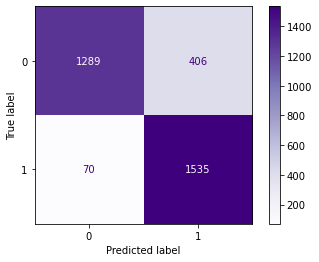

<Figure size 7200x7200 with 0 Axes>

In [99]:
#Plotting the confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='Purples', values_format='d');
plt.figure(figsize=(100, 100));

We definitely had difficulty correctly predicting our fantasy (0) class with 406 False Positives vs only 70 False Negatives.

---

**Random Forest Model**

Now I'll run the Random Forest model. I'll be using a pipeline to calculate the best hyperparameters for my CountVectorizer and for the Random Forest. I'll utilize the hyperparams that worked for the Bernoulli model to start with to see if they also work with Random Forest.

In [88]:
#Re-establishing X, y, and my train-test-split
X=df['title_selftext']
y=df['is_horror']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=111)

In [89]:
#Instantiating CountVectorizer and RandomForestClassifier
pipe_cv_rf=Pipeline([
    ('cv', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state=111))
])

This code should let me generate a dataframe with each of the different hyperparameters to gauge which ones work best for this model.

In [90]:
count=0
#Creating an empty dictionary for our parameters as a dictionary can easily be converted 
#to a dataframe.
model_params={}

In [91]:
#Setting these so they are overwritten each time this is run.
model_params=model_params
count=count

#Setting up my gridsearch params starting with CounterVectorizer.
params={
    'rf__n_estimators'      : [15],
    'rf__max_features'      : [None],
    'rf__max_depth'         : [10],
    'rf__min_samples_split' : [2],
    'rf__ccp_alpha'         : [0.0001],
    'cv__stop_words'   : [stpwrd],
    'cv__max_features' : [15],
    'cv__min_df'       : [0.000001],
    'cv__max_df'       : [0.25],
    'cv__ngram_range'  : [(1, 1)]
}

gs_rf= GridSearchCV(estimator=pipe_cv_rf, param_grid=params, cv=5, n_jobs=6)

gs_rf.fit(X_train, y_train)

count+=1

#This will give us the best params (based on the hyperparams we've entered)

#We need to add our accuracy score (best_score_) to our model_params before we create our dataframe.
gs_rf.best_params_['score']=gs.best_score_

model_params[f'model_{count}']= gs_rf.best_params_

model_df=pd.DataFrame.from_dict(model_params, orient='index')

model_df

,cv__max_df,cv__max_features,cv__min_df,cv__ngram_range,cv__stop_words,rf__ccp_alpha,rf__max_depth,rf__max_features,rf__min_samples_split,rf__n_estimators,score
model_1,0.25,15,0.000001,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, y...",0.0001,10,None,2,15,0.853134


Now that I've found the best hyperparameters for my model, let's take a look at it's scores.

In [92]:
#Taking a look at the best score
rnd_frst_accur=gs_rf.best_score_
rnd_frst_accur

0.8561194029850746

In [93]:
# Scoring model on training set.
rnd_frst_train_score=gs_rf.score(X_train, y_train)
rnd_frst_train_score

0.8640298507462687

In [94]:
# Scoring model on testing set.
rnd_frst_test_score=gs_rf.score(X_test, y_test)
rnd_frst_test_score

0.8596969696969697

In [95]:
#Getting the difference between the testing and training set.
rnd_frst_var=((gs_rf.score(X_train, y_train) - gs_rf.score(X_test, y_test)))
rnd_frst_var

0.0043328810492989644

With an accuracy score of 85.61% the Random Forest model definitely beat our baseline accuracy of 50% and did slightly better than the Bernoulli model's 85.15% accuracy. It has slightly more variance with 0.004332 difference between the training and testing sets versus 0.004265 for the Bernoulli model. Taking a look at our predictions and confusion matrix for this model.

In [96]:
#Getting predictions with our gridsearch on our X_test data.
preds_rf=gs_rf.predict(X_test)

# Saving confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_rf).ravel()

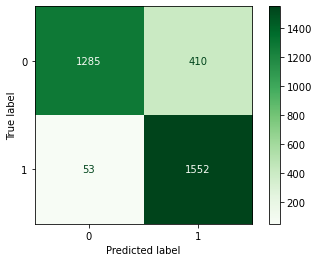

<Figure size 7200x7200 with 0 Axes>

In [97]:
#Plotting the confusion matrix
plot_confusion_matrix(gs_rf, X_test, y_test, cmap='Greens', values_format='d');
plt.figure(figsize=(100, 100));

The Random Forest model did noticeably better at predicting our horror (1) class with only 53 False Negatives. However it did slightly worse in predicting our fantasy (0) class with 410 False Positives. 

---

## Conclusion & Recommendations

Although the Random Forest model was more accurate than the Bernoulli Naive Bayes model it was by a fairly slim margin. Either of these models can be used to give excellent results.

Going forward, I would recommend dedicating more time to building-out an even more robust stop words list to improve accuracy even more. I’d also recommending testing a Logistic Regression model for further comparison.

---

## Resources

- https://fortune.com/2020/07/15/ecommerce-online-shopping-coronavirus-business-trends-covid/
- https://healthtechmagazine.net/article/2021/07/how-can-healthcare-leverage-natural-language-processing-medical-records-perfcon
- https://en.wikipedia.org/wiki/Natural_language_processing 
- https://en.wikipedia.org/wiki/Random_forest
- https://en.wikipedia.org/wiki/Bayes'_theorem
- https://github.com/pushshift/api
- https://www.reddit.com/r/horror/
- https://www.reddit.com/r/Fantasy/
